# Mapping Swiss Ecosystems from Aerial Images and Environmental Variables

This notebook presents the analyses and data pipeline for the project.  
It demonstrates that this pipeline is fully reproducible and provides a systematic workflow for mapping ecosystems in Switzerland using both aerial imagery and environmental variables.


---

## 📂 Project Folder Structure

**Root project folder:** `project/`

- `data/`
  - `images.zip/`            ← Aerial images, named by ID (e.g., 2572824_1174283.tif)  
  - `dataset_split.csv`  ← Tabular data with IDs, split, SWECO variables, EUNIS labels
- `figures/`                 ← Save different plots
- `models/`                   ← Save the best model for different architecture and parameters
- `utils/`  
  - `eunis_labels.py`                  ← Mapping from numeric ID to EUNIS label  
  - `sweco_group_of_variables.py`      ← SWECO variable thematic groups
  - `scripts.py`                       ← Python scripts with utils functions
- `ipeo_project.ipynb` ← Notebook: pipeline, results, plots, discussion
- `inference.ipynb` ← Notebook: test the best model on a few samples of the test set
- `experiment_log.csv` ← CSV to store performance for different models and hyperparameters
- `README.md` ← Project overview, instructions, dependencies  
- `pip_requirements.txt` ← Python dependencies  
- `envrionment.yml` ← Python dependencies 

---

## 🧭 Table of Contents

1. [Header & Setup](#1)

2. [Introduction](#2)  
   2.1 [Context and Motivation](#21)  
   2.2 [Objectives of the Project](#22)

3. [Data Loading & Description](#3)  
   3.1 [Overview of the Dataset](#31)  
   3.2 [Data loading](#32)  
   3.3 [Check & Clean SWECO Variables](#33)  
   3.4 [Train / Validation / Test Split](#34)  
   3.5 [Ecosystem Labels (EUNIS)](#35)  
   3.6 [Environmental Variables (SWECO25)](#36)  
   3.7 [Aerial Images Overview](#37)

4. [Data Preprocessing](#4)  
   4.1 [Image Preprocessing](#41)  
   4.2 [Tabular Data Preprocessing](#42)

5. [Methodology](#5)  
   5.1 [Problem Formulation](#51)  
   5.2 [Image-Based Model](#52)  
   5.3 [Tabular-Only Model](#53)  
   5.4 [Multimodal Model (Images + Environmental Variables)](#54)  
   5.5 [Loss Function and Optimization](#55)

6. [Experimental Design](#6)  
   6.1 [Compared Models](#61)  
   6.2 [Ablation Study on Environmental Variables](#62)  
   6.3 [Training Setup and Hyperparameter Selection](#63)

7. [Evaluation Metrics](#7)  
   7.1 [Classification Metrics](#71)  
   7.2 [Computational Performance](#72)

8. [Hyperparameter & Model Exploration](#8)  
   8.1 [Quantitative Results on Training and Validation Set](#81)  
   8.2 [Best model choice](#82)  

9. [Visual Analysis](#9)  
   9.1 [Confusion Matrices](#91)  
   9.2 [Feature Importance Analysis](#92)  
   9.3 [Spatial Visualization](#93)

10. [Discussion](#10)  
    10.1 [Key Findings](#101)  
    10.2 [Scientific Interpretation](#102)  
    10.3 [Limitations](#103)

11. [Conclusion and Future Work](#11)

12. [Reproducibility](#12)  
    12.1 [Code Organization](#121)  
    12.2 [How to Run](#122)

13. [References](#13)

<a id="1"></a>
## 1. Header & Setup

All required dependencies are listed in `pip_requirements.txt`

You can run the cell below to install them :

In [1]:
%pip install -r pip_requirements.txt

Note: you may need to restart the kernel to use updated packages.


📌 Imports & global setup

In [2]:
# =========================
# Reproducibility settings
# =========================
SEED = 42

import os
import random
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Python & NumPy
random.seed(SEED)
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Global seed set to {SEED}")

Using device: cpu
Global seed set to 42


In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Ensure directories exist
os.makedirs("models", exist_ok=True)
os.makedirs("figures", exist_ok=True)

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import zipfile
import time
import tifffile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tifffile import imread
from io import BytesIO
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from shapely.geometry import Point
import importlib
import sys

# System path
sys.path.insert(0, os.path.abspath('.'))

# Project utilities
from utils.sweco_group_of_variables import sweco_variables_dict
from utils import scripts
importlib.reload(scripts)
from utils.scripts import log_experiment, select_best_experiments, plot_experiments, base_model_name

# Display options
pd.set_option("display.max_columns", 10)
plt.style.use("seaborn-v0_8")

print("Setup complete")

Setup complete


<a id="2"></a>
## 2. Introduction

<a id="21"></a>
### 2.1 Context and Motivation

Accurate mapping of ecosystems is essential for biodiversity monitoring, land management, and environmental policy. In Switzerland, ecosystem types are shaped by complex interactions between climate, geology, land use, and human activity. Recent advances in deep learning and remote sensing enable large-scale ecosystem mapping using high-resolution aerial imagery, while ecological raster databases provide complementary environmental information.

This project investigates how aerial imagery and environmental variables contribute to ecosystem classification, and how they can be combined effectively in a multimodal deep learning framework.

---

<a id="22"></a>
### 2.2 Objectives of the Project

The objectives of this project are to:

- Predict EUNIS ecosystem categories (17 classes) across Switzerland
- Compare the predictive performance of:
    - Image-only models
    - Environmental-variable-only models
    - Combined multimodal models
- Perform an ablation study on thematic groups of environmental variables
- Analyse which ecological information is captured by imagery and which is uniquely provided by environmental variables
- Provide an interpretable scientific discussion of the results and their limitations

<a id="3"></a>
## 3. Data Loading & Description

This section loads the dataset, performs initial cleaning, splits the data, and provides visual exploration of the variables and images.

---

<a id="31"></a>
### 3.1 Overview of the Dataset

The dataset contains 16,925 georeferenced locations distributed across Switzerland.  
Each location includes:
- One aerial RGB image (swissIMAGE, 100 × 100 m at 50cm resolution)
- 48 standardized numerical environmental variables (SWECO25)
- One ecosystem label from the EUNIS framework

The data are split geographically to avoid spatial autocorrelation:
- Training set: 60%
- Validation set: 10%
- Test set: 30%

The validation set is used to choose the best model. The final results are computed on the test set.

---

<a id="32"></a>
### 3.2 Tabular Data Loading

In [4]:
# Path to dataset CSV
csv_path = "data/dataset_split.csv"

# Load CSV
df = pd.read_csv(csv_path)
print("Dataset loaded with shape:", df.shape)

# Display column names
columns_list = list(df.columns)
print(columns_list)

# Inspect first few rows
df.head()

Dataset loaded with shape: (16925, 58)
['id', 'x', 'y', 'split', 'EUNIS_cls', 'EUNIS_label', 'bioclim_precipitation', 'bioclim_precipitation_of_driest_quarter', 'bioclim_precipitation_of_wettest_quarter', 'bioclim_maximum_temperature', 'bioclim_minimum_temperature', 'bioclim_mean_temperature_of_driest_quarter', 'bioclim_mean_temperature_of_wettest_quarter', 'bioclim_isothermality_', 'bioclim_temperature_seasonality_(standard_deviation_x100)', 'bioclim_aridity_index', 'bioclim_evapotranspiration', 'lulc_arable_land_100', 'lulc_plantations_fields_and_crops_100', 'lulc_herbaceous_crops_100', 'lulc_woody_plant_crops_100', 'lulc_vineyards_100', 'lulc_meadows_100', 'lulc_wetlands_100', 'lulc_vegetated_shoreline_100', 'lulc_scree_100', 'lulc_roads_rails_paths_100', 'lulc_public_parks_100', 'lulc_high_altitude_grasslands_and_rough_pastures_100', 'lulc_herbaceous_crops_100.1', 'lulc_grasslands_and_meadows_100', 'lulc_glaciers_rocks_scree_and_moraines_100', 'lulc_buildings_100', 'lulc_arable_lan

id        x        y  split  EUNIS_cls  ...  \
0  2572824_1174283  2572824  1174283    val         12  ...   
1  2698259_1262891  2698259  1262891   test          9  ...   
2  2761449_1177676  2761449  1177676  train         14  ...   
3  2491055_1116825  2491055  1116825   test          1  ...   
4  2653828_1212723  2653828  1212723  train         12  ...   

  vege_canopy_height_max_100  vege_coniferous_leaf_type_100  \
0                  -1.148926                      -0.518092   
1                   2.063838                       2.862511   
2                  -0.202006                      -0.331415   
3                  -1.024924                      -0.523926   
4                  -0.585283                      -0.523926   

   vege_deciduous_leaf_type_100  lulc_normal_dense_forest_100  \
0                     -0.819660                     -0.662366   
1                      0.252738                      2.475530   
2                     -0.434967                     -0.682101   
3                     -0.614139                     -0.472908   
4                     -0.687916                     -0.678154   

   lulc_forests_100  
0         -0.918786  
1          2.149212  
2         -0.575265  
3         -0.683849  
4         -0.812176  

[5 rows x 58 columns]

<a id="33"></a>

### 3.3 Check & Clean SWECO Variables

The CSV initially contains 58 columns instead of the expected 48 SWECO variables (plus 6 non-feature columns).

Some column names were duplicated (.1 suffix). We check duplicates and remove them if values are identical.

In [5]:
# Number of rows to check
n_check = 20

# Copy to avoid modifying original
df_clean = df.copy()

for col in df.columns:
    if col.endswith('.1'):
        base_col = col[:-2]
        if base_col in df.columns:
            # Compare first n_check rows
            if df_clean[base_col].head(n_check).equals(df_clean[col].head(n_check)):
                print(f"Column '{col}' is a duplicate of '{base_col}' (first {n_check} rows identical). Dropping '{col}'")
                df_clean.drop(columns=[col], inplace=True)
            else:
                print(f"Column '{col}' differs from '{base_col}' (not dropping)")

print(f"Shape after cleaning: {df_clean.shape}")
df_clean.head()

Column 'lulc_herbaceous_crops_100.1' is a duplicate of 'lulc_herbaceous_crops_100' (first 20 rows identical). Dropping 'lulc_herbaceous_crops_100.1'
Column 'lulc_arable_land_100.1' is a duplicate of 'lulc_arable_land_100' (first 20 rows identical). Dropping 'lulc_arable_land_100.1'
Column 'lulc_glaciers_rocks_scree_and_moraines_100.1' is a duplicate of 'lulc_glaciers_rocks_scree_and_moraines_100' (first 20 rows identical). Dropping 'lulc_glaciers_rocks_scree_and_moraines_100.1'
Column 'lulc_scree_100.1' is a duplicate of 'lulc_scree_100' (first 20 rows identical). Dropping 'lulc_scree_100.1'
Shape after cleaning: (16925, 54)


id        x        y  split  EUNIS_cls  ...  \
0  2572824_1174283  2572824  1174283    val         12  ...   
1  2698259_1262891  2698259  1262891   test          9  ...   
2  2761449_1177676  2761449  1177676  train         14  ...   
3  2491055_1116825  2491055  1116825   test          1  ...   
4  2653828_1212723  2653828  1212723  train         12  ...   

  vege_canopy_height_max_100  vege_coniferous_leaf_type_100  \
0                  -1.148926                      -0.518092   
1                   2.063838                       2.862511   
2                  -0.202006                      -0.331415   
3                  -1.024924                      -0.523926   
4                  -0.585283                      -0.523926   

   vege_deciduous_leaf_type_100  lulc_normal_dense_forest_100  \
0                     -0.819660                     -0.662366   
1                      0.252738                      2.475530   
2                     -0.434967                     -0.682101   
3                     -0.614139                     -0.472908   
4                     -0.687916                     -0.678154   

   lulc_forests_100  
0         -0.918786  
1          2.149212  
2         -0.575265  
3         -0.683849  
4         -0.812176  

[5 rows x 54 columns]

<a id="34"></a>

### 3.4 Train / Validation / Test Split

We split the cleaned DataFrame by the provided split column. The provided split is used without modification to:

- Prevent spatial leakage
- Ensure a fair evaluation of generalization performance

In [6]:
train_df = df_clean[df_clean['split'] == 'train'].reset_index(drop=True)
val_df   = df_clean[df_clean['split'] == 'val'].reset_index(drop=True)
test_df  = df_clean[df_clean['split'] == 'test'].reset_index(drop=True)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 10200, Validation: 1625, Test: 5100


<a id="35"></a>

### 3.5 Ecosystem Labels (EUNIS)

Ecosystem classes follow the European Nature Information System (EUNIS) framework and include 17 categories such as grasslands, forests, cultivated areas, and built environments.

Each sample is associated with:
- A numeric class ID (EUNIS_cls)
- A descriptive label (EUNIS_label)

We visualize the number of samples per ecosystem class across train and validation sets. The test set is not shown to avoid peeking.

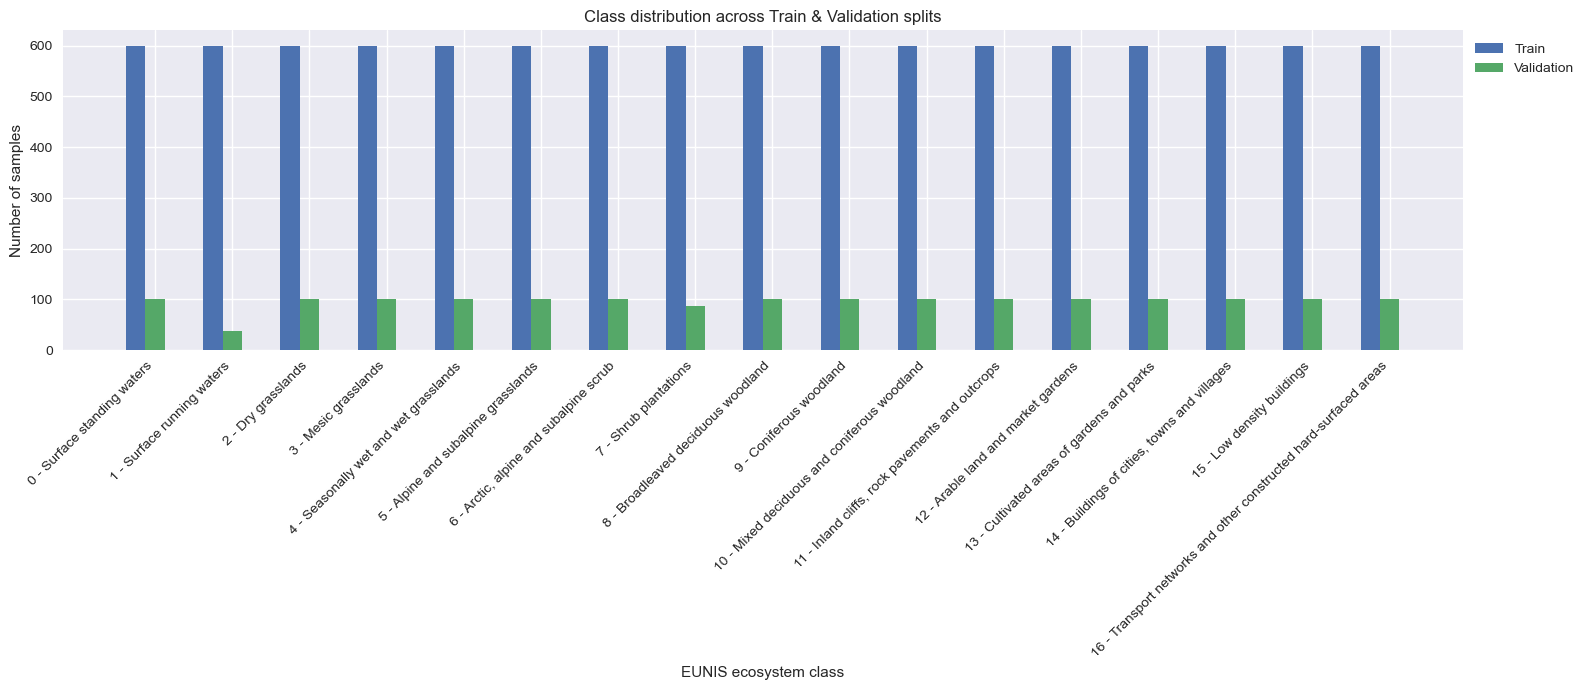

In [7]:
# Count samples per label per split
counts = (df_clean.groupby(['EUNIS_cls', 'EUNIS_label', 'split']).size().unstack(fill_value=0).loc[:, ['train', 'val', 'test']])

# Sort by class number (EUNIS_cls)
counts = counts.sort_index(level=0)

# Plot setup
x = np.arange(len(counts))
width = 0.25

plt.figure(figsize=(16, 7))
plt.bar(x - width, counts['train'], width, label='Train')
plt.bar(x,         counts['val'],   width, label='Validation')

# Rotate labels and show numeric class + label
xticks_labels = [f"{cls} - {label}" for cls, label in counts.index]
plt.xticks(x, xticks_labels, rotation=45, ha='right')

plt.ylabel("Number of samples")
plt.xlabel("EUNIS ecosystem class")
plt.title("Class distribution across Train & Validation splits")

# Place legend outside plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig(f"figures/class_distribution.png", dpi=300)
plt.show()

The training set shows an almost uniform distribution across the 17 ecosystem classes, while the validation set exhibits class imbalance, with some underrepresented classes such as Surface running waters (Class 1) and Shrub plantations (Class 7). This imbalance suggests that accuracy alone may be insufficient to properly assess model performance. Therefore, additional evaluation metrics, including macro-averaged F1 score, will be explored in later analyses to ensure balanced performance across all classes.

<a id="36"></a>

### 3.6 Environmental Variables (SWECO25)

The dataset includes 48 numerical variables, standardized to zero mean and unit variance, grouped into thematic categories:
- Bioclimatic
- Edaphic (soil)
- Vegetation
- Land use / land cover (LULC)
- Geology
- Hydrology
- Population and infrastructure

Thematic groupings are used to perform ablation studies.

We inspect the number of variables per SWECO thematic group.

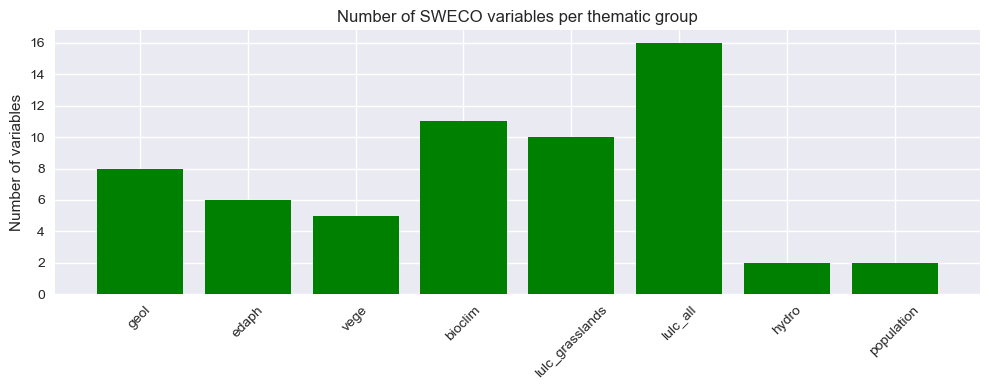

In [8]:
group_counts = {group: len(vars_list) for group, vars_list in sweco_variables_dict.items()}

plt.figure(figsize=(10,4))
plt.bar(group_counts.keys(), group_counts.values(), color='green')
plt.ylabel("Number of variables")
plt.title("Number of SWECO variables per thematic group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"figures/sweco_thematic_groups.png", dpi=300)
plt.show()

The 48 SWECO variables are unevenly distributed across the thematic groups. Some groups contain only a small number of variables (as few as two), while others are more densely represented, with the largest group comprising up to 16 variables. Most thematic groups include between 5 and 11 variables. This heterogeneous distribution is taken into account when performing ablation studies, as groups with more variables may contribute more strongly to model performance simply due to their higher dimensionality.

<a id="37"></a>

### 3.7 Aerial Images Overview
These high-resolution images capture fine-scale spatial patterns relevant for ecosystem discrimination.

- Source: swissIMAGE (swisstopo)
- Spatial resolution: 50 cm
- Image coverage: 100 × 100 meters
- RGB channels only

We first check if some images are missing relative to the Tabular data.

In [9]:
zip_path = "data/images.zip"

with zipfile.ZipFile(zip_path, 'r') as archive:
    available_images = {name.replace('.tif', '') for name in archive.namelist()}

missing_images = set(df_clean['id'].astype(str)) - available_images
print(f"Missing images: {len(missing_images)}")

Missing images: 0


#### 3.7.1 Image loading function

The function below load the RGB aerial image from a zip and return a PIL image in RGB format.

In [10]:
def load_image_from_zip(zip_path, img_id):
    """
    Load an RGB aerial image from a zip archive using tifffile (robust for GeoTIFF).
    Returns a PIL Image in RGB format.
    """
    with zipfile.ZipFile(zip_path, 'r') as archive:
        with archive.open(f"{img_id}.tif") as file:
            img_array = imread(BytesIO(file.read()))

    # Ensure uint8 format for visualization / PIL
    if img_array.dtype != np.uint8:
        img_array = img_array.astype(np.uint8)

    # Some TIFFs may be (H, W, C) already
    # Ensure RGB
    if img_array.ndim == 3 and img_array.shape[2] >= 3:
        img_array = img_array[:, :, :3]
    else:
        raise ValueError(f"Unexpected image shape for {img_id}: {img_array.shape}")

    return Image.fromarray(img_array, mode="RGB")

#### 3.7.2 Apply the predefined split to images

For image data, the train/validation/test split is represented by lists of image identifiers. Images are loaded on-the-fly from the archive using these identifiers to avoid unnecessary memory usage.

In [11]:
# Images are linked to tabular data via the 'id' column
image_train_ids = train_df['id'].tolist()
image_val_ids   = val_df['id'].tolist()
image_test_ids  = test_df['id'].tolist()

print(f"Number of training images: {len(image_train_ids)}")
print(f"Number of validation images: {len(image_val_ids)}")
print(f"Number of test images: {len(image_test_ids)}")

Number of training images: 10200
Number of validation images: 1625
Number of test images: 5100


We display a few random images from the training set to visualize ecosystem types.

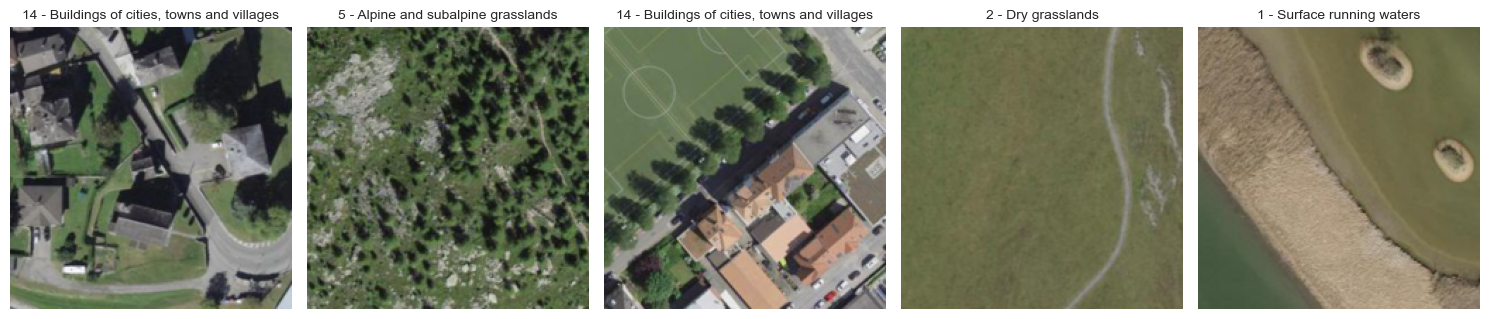

In [12]:
n_samples = 5

sample_rows = train_df.sample(n=n_samples, random_state=SEED)

fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img = load_image_from_zip(zip_path, row['id'])

    axes[i].imshow(img)
    axes[i].set_title(f"{row['EUNIS_cls']} - {row['EUNIS_label']}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

This subset of training images show the difficulty to correctly map Ecosystems to region with changing surface properties.

## 4. Data Preprocessing

<a id="41"></a>

### 4.1 Image Preprocessing

Aerial RGB images are preprocessed using a sequence of standard transformations designed to ensure compatibility with convolutional neural networks (CNNs) and to improve model generalization. All images are resized to a fixed spatial resolution, converted to tensors, and normalized using ImageNet statistics, which are commonly employed when working with CNNs pretrained on natural images.

Although the spectral characteristics of aerial imagery differ from those of the ImageNet dataset, normalization with ImageNet mean and standard deviation provides a stable and widely adopted baseline. This practice has been shown to generalize well across domains and facilitates effective transfer learning from pretrained models.

Data augmentation is applied exclusively to the training set in order to reduce overfitting and increase robustness to variations in illumination and orientation. It increases the diversity of the training data without increasing the dataset size, by applying random transformations on-the-fly during training. The augmentation strategies used are standard in computer vision and were selected to enhance model robustness without altering the semantic content of the images:
- **Random horizontal and vertical flips** : Introduce orientation invariance, which is particularly important for aerial imagery where objects may appear in any direction.
- **Color jitter (brightness=0.2, contrast=0.2, saturation=0.2)** : Applies mild variations in illumination and color distribution to reduce sensitivity to lighting conditions and sensor differences. These parameter values are commonly used in the literature and provide noticeable yet controlled variability.
- **Resizing to 224 × 224 pixels** : Ensures compatibility with standard CNN backbones such as ResNet and EfficientNet.
- **Normalization using ImageNet mean and standard deviation** : Aligns the input data distribution with that of pretrained weights, improving convergence and transfer learning performance.

Overall, these preprocessing and augmentation choices represent a well-established baseline. While they are not specifically tailored to aerial imagery, they provide a robust starting point and can be further refined if more domain-specific adjustments are required.

In [13]:
# Target image size (compatible with standard CNN backbones)
IMAGE_SIZE = 224

# ImageNet normalization statistics 
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Training image transformations (with augmentation)
train_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Validation / Test image transformations (no augmentation)
eval_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

Examples of transformations are shown below:

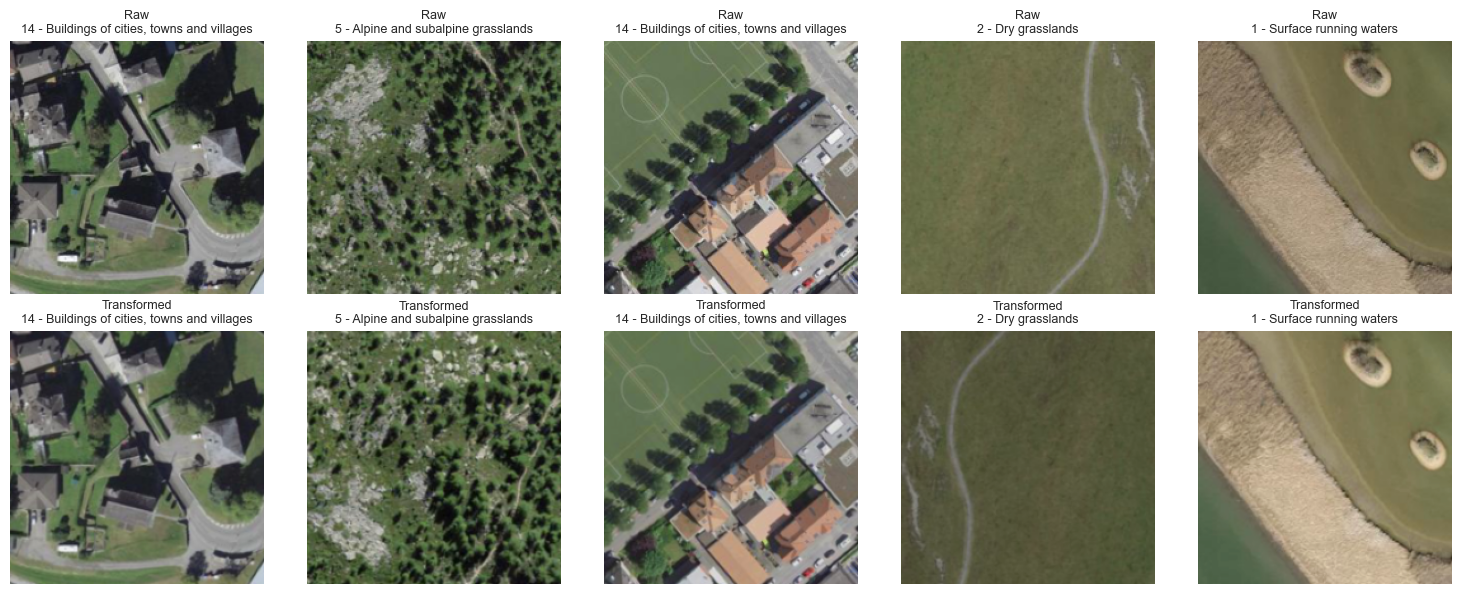

In [14]:
n_samples = 5
sample_rows = train_df.sample(n=n_samples, random_state=SEED)

fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_id = row['id']
    
    # --- Raw image ---
    raw_img = load_image_from_zip(zip_path, img_id)
    axes[0, i].imshow(raw_img)
    axes[0, i].set_title(
        f"Raw\n{row['EUNIS_cls']} - {row['EUNIS_label']}", fontsize=9
    )
    axes[0, i].axis('off')
    
    # --- Transformed image (augmentation + normalization) ---
    img = train_image_transform(raw_img)         
    img = img.permute(1, 2, 0).numpy()             # C,H,W → H,W,C

    # Unnormalize ONLY for visualization
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)

    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Transformed\n{row['EUNIS_cls']} - {row['EUNIS_label']}", fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(f"figures/transformation_images.png", dpi=300)
plt.show()

<a id="42"></a>

### 4.2 Tabular Data Preprocessing

- Check missing values in SWECO variables

>**Note** : No standardization is required (the dataset was already standardized)

In [15]:
# Define non-variable columns
non_variable_cols = ['id', 'x', 'y', 'split', 'EUNIS_cls', 'EUNIS_label']

# All SWECO variables in the dataset
sweco_variables = [col for col in df_clean.columns if col not in non_variable_cols]
print(f"Number of SWECO variables: {len(sweco_variables)}")

# Check missing values
missing_counts = df_clean[sweco_variables].isna().sum()

# Display missing values with friendly message
if missing_counts.sum() == 0:
    print("No missing values across all SWECO variables.")
else:
    print("Missing values per SWECO variable:")
    print(missing_counts[missing_counts > 0])

Number of SWECO variables: 48
No missing values across all SWECO variables.


<a id="5"></a>
## 5. Methodology

<a id="51"></a>
### 5.1 Problem Formulation

The task is formulated as a multiclass classification problem with 17 mutually exclusive ecosystem classes.
Inputs:
- RGB aerial image
- Environmental variable vector

Output:
- Probability distribution over EUNIS classes

---

<a id="52"></a>

### 5.2 Image-Based Models

To address the EUNIS classification task from aerial imagery, convolutional neural networks (CNNs) pretrained on ImageNet are employed. Pretraining enables the models to leverage robust low- and mid-level visual features (e.g., edges, textures, and shapes), which is particularly beneficial given the limited size of the available dataset and improves generalization performance.

All image-based models in this study rely on ResNet-50 as a common backbone. ResNet-50 is a deep convolutional architecture composed of 50 layers and residual connections, which mitigate the vanishing gradient problem and allow for effective training of deep networks. Its strong representational capacity and widespread adoption make it a well-established choice for transfer learning in remote sensing and aerial image analysis.

Three distinct architectures are built upon this shared ResNet-50 backbone:

- **ResNet-50 Baseline**

    A standard fine-tuning approach in which the pretrained ResNet-50 backbone is followed by a classification head. This model serves as a strong reference point for evaluating more advanced feature aggregation strategies.
- **Hypercolumn ResNet-50**
    
    Feature maps are extracted from multiple intermediate layers of the backbone and concatenated to form a hypercolumn representation. This design captures both fine-grained spatial details from shallow layers and high-level semantic information from deeper layers, enabling multi-scale feature learning.
- **CNN + Residual MLP**
    
    Global features extracted from the ResNet-50 backbone are pooled and passed through a residual multilayer perceptron (MLP) with skip connections. This architecture combines convolutional feature extraction with flexible fully connected modeling, allowing non-linear interactions among learned image features.

Across all image-based models, early layers of the backbone may be frozen while deeper layers and the classification head are fine-tuned. The final prediction is obtained through a global pooling operation followed by fully connected layers producing a 17-dimensional output corresponding to the target EUNIS classes.

By reusing a common ResNet-50 backbone, this framework enables a controlled comparison of different architectural strategies for image-based ecosystem classification.

#### 5.2.1 ResNet-50 Baseline
 A standard ResNet-50 pretrained on ImageNet is used as the backbone. Early layers are frozen to retain pretrained low-level features, while the final block and classifier are fine-tuned. The final classification head outputs probabilities for 17 EUNIS classes. This serves as a strong baseline model

In [16]:
class ImageResNet50(nn.Module):
    def __init__(self, n_classes=17, pretrained=True, freeze_backbone=True):
        super().__init__()
        weights = ResNet50_Weights.DEFAULT if pretrained else None
        self.backbone = resnet50(weights=weights)
        
        # Optionally freeze early layers
        if freeze_backbone:
            for name, param in self.backbone.named_parameters():
                if "layer4" not in name:  # fine-tune only last block
                    param.requires_grad = False
        
        # Replace final classifier
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, n_classes)

    def forward(self, x):
        return self.backbone(x)

#### 5.2.2 Hypercolumn ResNet-50
This model extracts multi-scale features from four stages of ResNet-50. Each feature map is globally pooled and concatenated to form a hypercolumn vector, capturing both low-level textures and high-level semantic features. The hypercolumn is fed into an MLP classifier. This approach is particularly effective when fine spatial details are important.

In [17]:
class ImageHypercolumnResNet(nn.Module):
    def __init__(self, n_classes=17, pretrained=True):
        super().__init__()
        weights = ResNet50_Weights.DEFAULT if pretrained else None
        resnet = resnet50(weights=weights)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 1024 + 512 + 256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        f0 = self.layer0(x)
        f1 = self.layer1(f0)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)

        # Global average pooling for each layer
        g0 = F.adaptive_avg_pool2d(f1, 1).view(x.size(0), -1)
        g1 = F.adaptive_avg_pool2d(f2, 1).view(x.size(0), -1)
        g2 = F.adaptive_avg_pool2d(f3, 1).view(x.size(0), -1)
        g3 = F.adaptive_avg_pool2d(f4, 1).view(x.size(0), -1)

        # Concatenate hypercolumn
        hc = torch.cat([g0, g1, g2, g3], dim=1)
        out = self.classifier(hc)
        return out

#### 5.2.3 CNN + Residual MLP
Features are first extracted using a ResNet-50 backbone. The pooled features are then fed into a residual MLP with skip connections and dropout for regularization. This hybrid design combines pretrained CNN features with flexible fully connected layers, providing a balance between model complexity and training stability

In [18]:
class ImageCNNFeatureMLP(nn.Module):
    def __init__(self, n_classes=17, pretrained=True, hidden_dim=256, n_blocks=2, dropout=0.3):
        super().__init__()
        # Pretrained backbone
        weights = ResNet50_Weights.DEFAULT if pretrained else None
        resnet = resnet50(weights=weights)
        self.backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        in_dim = 2048
        
        # Residual MLP
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(n_blocks):
            layers.append(ResidualBlock(hidden_dim, dropout))
        layers.append(nn.Linear(hidden_dim, n_classes))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.mlp(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(dim, dim), nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))

#### 5.2.4 Image DataLoader Function

To streamline training and evaluation, a dedicated function is created to generate PyTorch DataLoaders for images.

Purpose: Load images in batches, apply transformations (augmentation for training, normalization for all), and pair them with corresponding class labels.

Implementation: A custom Dataset class reads images from a zip archive and applies the defined transformations. The *make_image_dataloaders* function wraps these datasets in DataLoaders for efficient batching.

In [19]:
class ZipImageDataset(Dataset):
    """Dataset to read images directly from a zip file using tifffile."""
    def __init__(self, zip_path, image_ids, labels, transform=None):
        self.zip_path = zip_path
        self.image_ids = image_ids
        self.labels = np.array(labels)  # convert to numpy array for indexing
        self.transform = transform

        # Open the zip file once to index available images
        with zipfile.ZipFile(self.zip_path, 'r') as archive:
            self.available_images = {name.replace('.tif', '') for name in archive.namelist()}

        # Filter out IDs that are missing
        valid_idx = [i for i, img_id in enumerate(self.image_ids) if img_id in self.available_images]
        self.image_ids = [self.image_ids[i] for i in valid_idx]
        self.labels = self.labels[valid_idx]

        print(f"Dataset initialized: {len(self.image_ids)} valid images, {len(valid_idx) - len(self.image_ids)} skipped images.")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        label = self.labels[idx]

        with zipfile.ZipFile(self.zip_path, 'r') as archive:
            with archive.open(f"{img_id}.tif") as file:
                try:
                    img_array = tifffile.imread(file)
                    if len(img_array.shape) == 2:
                        img_array = np.stack([img_array]*3, axis=-1)
                    elif img_array.shape[2] > 3:
                        img_array = img_array[:, :, :3]
                    img = Image.fromarray(img_array.astype('uint8'))
                except Exception as e:
                    print(f"Skipping image during __getitem__: {img_id} ({e})")
                    img = Image.new("RGB", (224,224), (0,0,0))

        if self.transform:
            img = self.transform(img)

        return img, label



def make_image_dataloaders(zip_path, train_ids, val_ids, y_train, y_val,
                           train_transform, val_transform, batch_size=32, n_train_samples=None, seed=42):
    """
    Create DataLoaders for training and validation from a zip file.
    Can take a random subset of training images by specifying n_train_samples.
    """
    if n_train_samples is not None and n_train_samples < len(train_ids):
        random.seed(seed)
        indices = random.sample(range(len(train_ids)), n_train_samples)
        train_ids = [train_ids[i] for i in indices]
        y_train = np.array(y_train)[indices]

    train_dataset = ZipImageDataset(zip_path, train_ids, y_train, transform=train_transform)
    val_dataset   = ZipImageDataset(zip_path, val_ids, y_val, transform=val_transform)

    # --- Reproducible shuffling ---
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

<a id="53"></a>
### 5.3 Tabular-Only Model

To model the environmental variables, we rely on neural networks specifically designed for tabular data. All models take standardized SWECO variables as input and predict one of the 17 ecosystem classes. The architectures are designed to balance expressive power and regularization, given the moderate dimensionality of the input feature space.

**General design choices**

All tabular models share the following characteristics:
- Input: standardized SWECO environmental variables
- Hidden layers: fully connected (dense) layers
- Activation function: ReLU, chosen for its stability and efficiency
- Regularization:
    - Batch Normalization to stabilize training
    - Dropout to reduce overfitting
- Output: a fully connected layer with 17 neurons, followed by a softmax implicitly handled by the cross-entropy loss

#### 5.3.1 Standard Multilayer Perceptron (MLP)

The first architecture is a classical multilayer perceptron (MLP), which serves as a strong baseline for tabular data. The model consists of a sequence of fully connected layers with decreasing dimensionality. This pyramidal structure encourages the network to learn progressively more abstract representations of the input variables.

Batch normalization is applied after each linear transformation to improve convergence, followed by ReLU activation and dropout for regularization.

This architecture is simple, interpretable, and commonly used as a reference model for tabular classification tasks.

In [20]:
class TabularMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[512, 256, 128], dropout=0.3, n_classes=17):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

#### 5.3.2 Shallow Multilayer Perceptron (MLP)
A second shallow MLP architecture was tested to evaluate whether a simpler network can achieve comparable performance while reducing the risk of overfitting.

Key differences from the standard MLP:
- Fewer hidden layers and smaller number of neurons per layer.
- Same use of batch normalization, ReLU activations, and dropout.

This helps assess the influence of model complexity on performance.

In [21]:
class TabularShallowMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128, 32], dropout=0.3, n_classes=17):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

#### 5.3.3 MLP with Skip Connections (Residual MLP)

While standard MLPs can be effective, deeper networks may suffer from optimization difficulties such as vanishing gradients. To address this, we introduce a second architecture inspired by residual learning, originally proposed for deep convolutional networks.

This model first projects the input features into a fixed-dimensional latent space. It then applies a sequence of residual blocks, where each block learns a transformation that is added to its input. This skip connection allows gradients to flow more easily through the network and encourages the model to learn incremental refinements rather than entirely new representations at each layer.

Residual connections are particularly useful when increasing network depth without significantly degrading performance.

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(dim, dim), nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(x + self.block(x))


class TabularSkipMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, n_blocks=3, dropout=0.3, n_classes=17):
        super().__init__()

        # Input projection
        self.input_layer = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.BatchNorm1d(hidden_dim), nn.ReLU())

        # Residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(hidden_dim, dropout) for _ in range(n_blocks)])

        # Output head
        self.output_layer = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        return self.output_layer(x)

#### 5.3.4 Tabular DataLoader Function
This function creates PyTorch DataLoaders for training and validation sets. It wraps the input tensors into a TensorDataset and returns DataLoaders with the specified batch size. The training loader is shuffled to improve generalization, while the validation loader preserves the original order.

In [23]:
def make_dataloaders(Xtrain, ytrain, Xval, yval, batch_size=32, n_train_samples=None, seed=42):
    """
    Create DataLoaders for tabular data.
    If n_train_samples is set, randomly selects a subset of the training data.
    """
    if n_train_samples is not None and n_train_samples < len(Xtrain):
        np.random.seed(seed)
        indices = np.random.choice(len(Xtrain), n_train_samples, replace=False)
        Xtrain = Xtrain[indices]
        ytrain = ytrain[indices]

    train_dataset = TensorDataset(Xtrain, ytrain)
    val_dataset   = TensorDataset(Xval, yval)

    # --- Reproducible shuffling ---
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

<a id="54"></a>
### 5.4 Multimodal Model (Images + Environmental Variables)

To jointly exploit spatial information from aerial imagery and ecological context from environmental variables, a multimodal neural network architecture is proposed. The model consists of two parallel branches (one processing tabular data and the other processing images) followed by feature-level fusion and joint classification.

**Tabular branch**

Environmental variables are processed by a multilayer perceptron (MLP) composed of fully connected layers with batch normalization, ReLU activations, and dropout regularization. This branch maps the input feature vector to a compact latent representation that captures non-linear relationships among environmental variables.

**Image branch**

Image features are extracted using a convolutional neural network based on a ResNet-50 backbone. Different image-based architectures can be selected within the multimodal framework. They correspond to the Image previously defined model :
- a **standard ResNet-50 feature** extractor
- a **hypercolumn-based ResNet-50** capturing multi-scale representations
- a **CNN followed by a residual MLP** for feature refinement

In all cases, the image branch outputs a fixed-length feature vector. When necessary, global average pooling is applied to convert spatial feature maps into a one-dimensional representation.

**Feature fusion and classification**

The latent representations from the tabular and image branches are concatenated to form a joint feature vector. This fused representation is then passed through a fully connected classification head, producing a probability distribution over the 17 EUNIS ecosystem classes.

By integrating complementary visual and environmental information at the feature level, this multimodal architecture enables the model to leverage both spatial patterns visible in aerial imagery and ecological context provided by tabular variables, leading to improved ecosystem classification performance compared to unimodal approaches.

In [24]:
class CombinedTabularImageModel(nn.Module):
    """
    Combines tabular data (MLP) and images (CNN) for classification.
    Possibility to choose the CNN architecture (from the Image defined).
    """
    def __init__(self, tabular_input_dim, n_classes=17, tabular_hidden=[128, 64], image_model='Resnet50', pretrained=True, dropout=0.3):
        super().__init__()

        # --- Tabular branch ---
        layers = []
        input_dim = tabular_input_dim
        for h in tabular_hidden:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = h
        self.tabular_mlp = nn.Sequential(*layers)
        tabular_feat_dim = tabular_hidden[-1]

        # --- Image branch ---
        if image_model == 'Resnet50':
            # Return feature vector instead of logits
            self.image_model = ImageResNet50(n_classes=2048, pretrained=pretrained, freeze_backbone=True)
            self.image_feat_dim = 2048
        elif image_model == 'Hypercolumn':
            self.image_model = ImageHypercolumnResNet(n_classes=2048 + 1024 + 512 + 256, pretrained=pretrained)
            self.image_feat_dim = 2048 + 1024 + 512 + 256
        elif image_model == 'CNNfeature':
            self.image_model = ImageCNNFeatureMLP(n_classes=256, pretrained=pretrained, hidden_dim=256, dropout=dropout)
            self.image_feat_dim = 256
        else:
            raise NotImplementedError(f"{image_model} not supported")

        # --- Fusion classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(tabular_feat_dim + self.image_feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, n_classes)
        )

    def forward(self, tabular_x, image_x):
        # Tabular branch
        tab_feat = self.tabular_mlp(tabular_x)
        
        # Image branch
        img_feat = self.image_model(image_x)
        if img_feat.ndim == 4:  # if backbone returns (B,C,H,W)
            img_feat = F.adaptive_avg_pool2d(img_feat, 1).view(img_feat.size(0), -1)

        # Concatenate features
        combined = torch.cat([tab_feat, img_feat], dim=1)
        out = self.classifier(combined)
        return out

#### 5.4.1 Tabular DataLoader Function

A custom dataset is implemented to jointly load tabular environmental variables and corresponding RGB aerial images for each sample. Tabular features are provided as preprocessed tensors, while images are loaded on-the-fly from a compressed archive and converted to RGB format when necessary. Only samples with valid image identifiers are retained to ensure consistency between modalities. Standard image preprocessing and augmentation are applied, with augmentation restricted to the training set. Dedicated data loaders are used to create training and validation splits, with optional subsampling of the training set for controlled experiments.

In [25]:
class CombinedDataset(Dataset):
    """
    Returns (tabular_features, image, label) for multimodal training.
    """
    def __init__(self, tabular_tensor, df, zip_path, image_ids, labels_column='EUNIS_cls', transform=None):
        """
        tabular_tensor : torch.Tensor of shape (N, n_features)
        df             : pandas DataFrame containing image IDs
        zip_path       : path to zip with images
        image_ids      : list of image IDs corresponding to df rows
        labels_column  : column name for labels in df
        transform      : torchvision transforms for images
        """
        self.tabular_tensor = tabular_tensor
        self.image_ids = image_ids
        self.labels = torch.tensor(df[labels_column].values, dtype=torch.long)
        self.transform = transform
        self.zip_path = zip_path

        # Preload available images
        with zipfile.ZipFile(self.zip_path, 'r') as archive:
            self.available_images = {name.replace('.tif', '') for name in archive.namelist()}

        # Keep only valid IDs
        valid_idx = [i for i, img_id in enumerate(self.image_ids) if img_id in self.available_images]
        self.tabular_tensor = self.tabular_tensor[valid_idx]
        self.image_ids = [self.image_ids[i] for i in valid_idx]
        self.labels = self.labels[valid_idx]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        tab_feat = self.tabular_tensor[idx]
        label = self.labels[idx]

        img_id = self.image_ids[idx]
        with zipfile.ZipFile(self.zip_path, 'r') as archive:
            with archive.open(f"{img_id}.tif") as file:
                try:
                    img_array = tifffile.imread(file)
                    if len(img_array.shape) == 2:
                        img_array = np.stack([img_array]*3, axis=-1)
                    elif img_array.shape[2] > 3:
                        img_array = img_array[:, :, :3]
                    img = Image.fromarray(img_array.astype('uint8'))
                except Exception as e:
                    print(f"Skipping image: {img_id} ({e})")
                    img = Image.new("RGB", (224,224), (0,0,0))

        if self.transform:
            img = self.transform(img)

        return tab_feat, img, label
    


def make_combined_dataloaders(tabular_train, tabular_val, train_df, val_df, zip_path, train_ids, val_ids,
                              train_transform, val_transform, batch_size=32, n_train_samples=None, seed=42):
    """
    Create DataLoaders for combined tabular + image data.
    Can take a random subset of the training set via n_train_samples.
    """
    # Select a subset if requested
    if n_train_samples is not None and n_train_samples < len(train_ids):
        random.seed(seed)
        indices = random.sample(range(len(train_ids)), n_train_samples)
        train_ids = [train_ids[i] for i in indices]
        tabular_train = tabular_train[indices]
        train_df = train_df.iloc[indices].reset_index(drop=True)

    train_dataset = CombinedDataset(tabular_train, train_df, zip_path, train_ids, transform=train_transform)
    val_dataset   = CombinedDataset(tabular_val, val_df, zip_path, val_ids, transform=val_transform)

    # --- Reproducible shuffling ---
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

<a id="55"></a>

### 5.5 Loss Function and Optimization

Ecosystem prediction is a multiclass classification task with mutually exclusive classes.  
We use **categorical cross-entropy** as the loss function. The original training data does not have class imbalance but in case of selecting of subset, a **class-weighted cross-entropy** can be automatically computed from the training labels.  

The optimizer is **Adam**, optionally with weight decay, and the learning rate can be scheduled during training.  

The following function *get_loss_optimizer* conveniently returns the criterion and optimizer. By setting `weighted=True`, it computes class weights automatically from the training labels.

In [26]:
def get_loss_optimizer(model, ytrain=None, lr=1e-3, weight_decay=0.0, weighted=False, device='cpu'):
    """
    Returns a criterion and optimizer for training a model.
    If weighted=True, computes class weights automatically from ytrain.
    
    Args:
        model: torch.nn.Module, the model to optimize
        ytrain: array-like, training labels (required if weighted=True)
        lr: float, learning rate
        weight_decay: float, weight decay for Adam optimizer
        weighted: bool, whether to use class-weighted loss
        
    Returns:
        criterion: loss function
        optimizer: optimizer
    """
    if weighted:
        if ytrain is None:
            raise ValueError("ytrain must be provided when weighted=True")
        classes = np.unique(ytrain)
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytrain)
        class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    return criterion, optimizer

<a id="6"></a>
## 6. Experimental Design

<a id="61"></a>
### 6.1 Compared Models

The following models are evaluated:
- Image-only model
- Tabular-only model (all SWECO variables)
- Multimodal model (image + all variables)

---

<a id="62"></a>
### 6.2 Ablation Study on Environmental Variables

We compute the contribution of individual SWECO variables by measuring the decrease in model performance (accuracy or chosen metric) when each feature is randomly permuted across the validation or test set. The resulting percentage importance represents the average drop in performance caused by perturbing that feature, indicating how much the model relies on it. Features are also grouped thematically, allowing calculation of mean importance per group.

The compute_group_permutation_importance function returns both individual feature importances and group-level means, while plot_permutation_importances visualizes the top features and relative contribution of each feature group. This approach provides a fast, ablation-style analysis without needing to retrain multiple models, highlighting which ecological drivers are most informative for ecosystem prediction

In [27]:
def compute_group_permutation_importance(model, X, y, feature_names, feature_groups, metric=accuracy_score, n_repeats=5, device='cpu'):
    """
    Compute permutation importance of features and aggregate by predefined groups.

    Args:
        model: Trained PyTorch model
        X: Input features (torch.Tensor)
        y: True labels (torch.Tensor)
        feature_names: List of feature names corresponding to X columns
        feature_groups: Dictionary mapping group_name -> list of feature names
        metric: Function to evaluate performance (default: accuracy_score)
        n_repeats: Number of permutations for stability

    Returns:
        feature_importances_pct: np.array of feature importances (% drop in metric)
        group_importances: dict of mean importance per group (%)
    """
    X = X.to(device)
    y = y.to(device)
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        base_preds = torch.argmax(model(X), dim=1)
        base_score = metric(y.cpu().numpy(), base_preds.cpu().numpy())

    importances = np.zeros(X.shape[1])
    
    for col in range(X.shape[1]):
        scores = []
        X_permuted = X.clone()
        for _ in range(n_repeats):
            perm = torch.randperm(X.shape[0])
            X_permuted[:, col] = X_permuted[perm, col]
            preds = torch.argmax(model(X_permuted), dim=1)
            scores.append(base_score - metric(y.cpu().numpy(), preds.cpu().numpy()))
        importances[col] = np.mean(scores)

    feature_importances_pct = importances * 100

    # Aggregate by group
    group_importances = {}
    for group_name, group_features in feature_groups.items():
        idx = [i for i, f in enumerate(feature_names) if f in group_features]
        if len(idx) > 0:
            group_importances[group_name] = feature_importances_pct[idx].mean()
        else:
            group_importances[group_name] = 0.0

    return feature_importances_pct, group_importances


def plot_permutation_importances(feature_importances_pct, feature_names, group_importances, top_n=20, 
                                 save_path_top=None, save_path_group=None):
    """
    Plot top N feature importances and group-level mean importances.

    Args:
        feature_importances_pct: np.array of feature importances (%)
        feature_names: list of feature names
        group_importances: dict mapping group_name -> mean importance (%)
        top_n: number of top features to display
        save_path_top: str, optional path to save top features figure
        save_path_group: str, optional path to save group-level figure
    """
    # --- Top features ---
    top_idx = np.argsort(feature_importances_pct)[-top_n:][::-1]
    plt.figure(figsize=(10,5))
    plt.barh(range(top_n), feature_importances_pct[top_idx])
    plt.yticks(range(top_n), np.array(feature_names)[top_idx])
    plt.gca().invert_yaxis()
    plt.xlabel("Permutation Importance (%)")
    plt.title(f"Top {top_n} SWECO Features")
    plt.tight_layout()
    if save_path_top:
        plt.savefig(save_path_top, dpi=300)
    plt.show()

    # --- Group-level importances ---
    groups_sorted = sorted(group_importances.items(), key=lambda x: x[1], reverse=True)
    plt.figure(figsize=(6,4))
    plt.bar([g[0] for g in groups_sorted], [g[1] for g in groups_sorted])
    plt.xticks(rotation=45)
    plt.ylabel("Mean Permutation Importance (%)")
    plt.title("Permutation Importance by Feature Group")
    plt.tight_layout()
    if save_path_group:
        plt.savefig(save_path_group, dpi=300)
    plt.show()

<a id="63"></a>

### 6.3 Training Setup and Hyperparameter Selection

#### 6.3.1 Hyperparameter Selection

The tabular MLP models are trained in a **supervised classification setup**, with hyperparameters tuned on the validation set to optimize predictive performance.

**Explored hyperparameters and their effects**:
- **Learning rate (1e-4, 3e-4, 1e-3):**
    - Controls the step size during gradient descent. Smaller values provide more stable but slower convergence, while larger values can speed up training but risk overshooting minima.
- **Batch size (16, 32):**
    - Determines the number of samples per gradient update. Smaller batches introduce more noise in gradient estimation, which can improve generalization; larger batches provide more stable updates but may converge to sharper minima.
- **Dropout rate (0.2, 0.5):**
     - Regularization technique that randomly zeroes a fraction of layer outputs during training. Higher dropout prevents overfitting but can slow convergence.
- **Weight decay (0, 1e-4):**
    - L2 regularization applied to the network weights to reduce overfitting. Larger values encourage smaller weights and smoother solutions.

**Selection criterion**:
The best configuration is chosen based on validation macro F1-score, which accounts for class imbalance.

**Regularization / stopping**:
- Early stopping is applied to prevent overfitting.
- Dropout and optional weight decay help regularize the network and improve generalization.

**Practical choices for this project**:
To limit the total number of experiments while still exploring key hyperparameter effects, a reduced set of five hyperparameter combinations was selected, covering a range of learning rates, batch sizes, dropout rates, and weight decay. These combinations are used for systematic comparison across model architectures in chapter 8.

In [28]:
hparams_list = [
    {"learning_rate": 1e-4, "batch_size": 16, "dropout_rate": 0.2, "weight_decay": 0},
    {"learning_rate": 1e-4, "batch_size": 32, "dropout_rate": 0.5, "weight_decay": 1e-4},
    {"learning_rate": 3e-4, "batch_size": 16, "dropout_rate": 0.5, "weight_decay": 0},
    {"learning_rate": 1e-3, "batch_size": 32, "dropout_rate": 0.2, "weight_decay": 1e-4},
    {"learning_rate": 1e-3, "batch_size": 16, "dropout_rate": 0.5, "weight_decay": 0}
]

#### 6.3.2 Tensor and Dataset Initialization

Tabular SWECO features and corresponding labels are converted into PyTorch tensors (float32 for inputs, long for class labels) to enable efficient batch training. Image and combined datasets are handled later in Chapter 8.

In [29]:
# Training tensors
Xtrain_tensor = torch.tensor(train_df[sweco_variables].values, dtype=torch.float32).to(device)
ytrain_tensor = torch.tensor(train_df['EUNIS_cls'].values, dtype=torch.long).to(device)

# Validation tensors
Xval_tensor = torch.tensor(val_df[sweco_variables].values, dtype=torch.float32).to(device)
yval_tensor = torch.tensor(val_df['EUNIS_cls'].values, dtype=torch.long).to(device)

# Test tensors
Xtest_tensor = torch.tensor(test_df[sweco_variables].values, dtype=torch.float32).to(device)
ytest_tensor = torch.tensor(test_df['EUNIS_cls'].values, dtype=torch.long).to(device)


#### 6.3.3 Model Training and Validation

The function trains a given model over multiple epochs, computing training loss, accuracy, and macro F1 at each epoch. It evaluates the model on a separate validation set and tracks the epoch with the highest validation F1-score. The best-performing model is saved automatically, and a history of metrics and epoch times is returned for monitoring and plotting training progress

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=100, save_path='best_tabular_model.pt', print_every=10, device='cpu'):
    """
    Trains the given model and evaluates on validation set per epoch.
    Stores the model with the best validation F1-score.

    Returns:
        history (dict): Train/validation metrics and epoch times
        best_epoch (int): Epoch with best validation F1
        total_time (float): Total training time in seconds
    """
    best_val_f1 = 0.0
    best_epoch = 0

    history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_acc": [], "val_f1": [], "epoch_time": []}

    total_start = time.time()

    for epoch in range(1, n_epochs + 1):
        start_epoch = time.time()
        model.train()

        train_losses = []
        train_preds, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()

            if len(batch) == 3:
                tabular_batch, image_batch, labels = batch
                tabular_batch = tabular_batch.to(device)
                image_batch = image_batch.to(device)
                labels = labels.to(device)
                preds = model(tabular_batch, image_batch)  # Combined model
            elif len(batch) == 2:
                xb, labels = batch
                xb = xb.to(device)
                labels = labels.to(device)
                preds = model(xb)  # Tabular or image-only model
            else:
                raise ValueError(f"Unexpected batch format: {batch}")
            
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_preds.append(preds.detach())
            train_labels.append(labels)

        # --- Train metrics ---
        avg_train_loss = sum(train_losses) / len(train_losses)
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)

        train_acc = accuracy_score(train_labels, train_preds.argmax(1))
        train_f1  = f1_score(train_labels, train_preds.argmax(1), average='macro')

        # --- Validation ---
        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    tabular_batch, image_batch, labels = batch
                    tabular_batch = tabular_batch.to(device)
                    image_batch = image_batch.to(device)
                    labels = labels.to(device)
                    preds = model(tabular_batch, image_batch)
                elif len(batch) == 2:
                    xb, labels = batch
                    xb = xb.to(device)
                    labels = labels.to(device)
                    preds = model(xb)
                else:
                    raise ValueError(f"Unexpected batch format: {batch}")
                
                val_preds.append(preds)
                val_labels.append(labels)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_acc = accuracy_score(val_labels, val_preds.argmax(1))
        val_f1  = f1_score(val_labels, val_preds.argmax(1), average='macro')

        # --- Save best ---
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)

        # --- Store history ---
        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["epoch_time"].append(time.time() - start_epoch)

        if epoch % print_every == 0 or epoch == 1:
            print(
                f"Epoch {epoch}/{n_epochs} | "
                f"Train Loss: {avg_train_loss:.4f} | "
                f"Train Acc: {train_acc:.3f}, Train F1: {train_f1:.3f} | "
                f"Val Acc: {val_acc:.3f}, Val F1: {val_f1:.3f}"
            )

    total_time = time.time() - total_start

    return history, best_epoch, total_time

<a id="7"></a>
## 7. Evaluation Metrics
<a id="71"></a>
### 7.1 Classification Metrics

The following metrics are computed on train, validation, and test sets:
- Overall accuracy
- Macro-averaged F1-score
- Per-class F1-score
- Confusion matrix

Macro-averaged metrics are emphasized to ensure fair evaluation of rare ecosystem classes.

The *evaluate_model* function computes overall accuracy, macro F1, and per-class F1 for a given model and dataset.

In [31]:
def evaluate_model(model, X, y):
    """
    Compute the accuracy, macro averaged F1-score and per-class F1-score
    """
    model.eval()
    device = next(model.parameters()).device
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        outputs = model(X)
        preds = outputs.argmax(1)

    acc = accuracy_score(y, preds)
    f1_macro  = f1_score(y, preds, average='macro')
    f1_per_class = f1_score(y, preds, average=None)

    return acc, f1_macro, f1_per_class

The *plot_per_class_f1* fuction displays a bar chart of F1 scores for each class, optionally showing class names.

In [32]:
def plot_per_class_f1(f1_per_class, class_labels=None, title="Per-Class F1 Score", save_path=None):
    """
    Plot per-class F1 scores, showing class number and name.

    Args:
        f1_per_class (array-like): F1 score for each class
        class_labels (list): Optional class names
        title (str): Plot title
    """
    n_classes = len(f1_per_class)
    if class_labels is None:
        class_labels = [f"{i+1}" for i in range(n_classes)]
    else:
        # Combine class number and name
        class_labels = [f"{i+1}. {name}" for i, name in enumerate(class_labels)]
    
    plt.figure(figsize=(12,6))
    plt.bar(np.arange(n_classes), f1_per_class, color='skyblue')
    plt.xticks(np.arange(n_classes), class_labels, rotation=90)
    plt.ylabel("F1 Score")
    plt.xlabel("Class")
    plt.title(title)
    plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

The *plot_confusion_matrix* function plots a (normalized) confusion matrix to visualize per-class prediction performance.

In [33]:
def plot_confusion_matrix(y_true, y_pred, class_labels, figsize=(10,10), normalize=True, cmap='Blues', title="Confusion Matrix", save_path=None):
    """
    Plots the confusion matrix.
    
    Args:
        y_true: array-like, true labels
        y_pred: array-like, predicted labels
        class_labels: list of label names
        figsize: tuple, figure size
        normalize: bool, whether to show percentages
        cmap: colormap
        title: figure title
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.1f'
    else:
        fmt = 'd'
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=cmap, values_format=fmt, xticks_rotation=90)
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

The *plot_training_curves* function plots accuracy and macro F1 over epochs for training and validation sets, optionally saving the figure.

In [34]:
def plot_training_curves(history, save_path=None):
    epochs = range(1, len(history["train_acc"]) + 1)

    plt.figure(figsize=(12,5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", linewidth=1)
    plt.plot(epochs, history["val_acc"], label="Val Accuracy", linewidth=1)
    plt.plot(epochs, history["train_f1"], '--', label="Train Macro F1")
    plt.plot(epochs, history["val_f1"], '--', label="Val Macro F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Training and Validation Performance")
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")    
    plt.show()

<a id="72"></a>
### 7.2 Computational Performance

Computational efficiency is assessed by measuring:
- Average training time per epoch
- Total training time
- Inference time per sample

In [35]:
def measure_inference_time(model, X):
    model.eval()
    device = next(model.parameters()).device
    X = X.to(device)
    with torch.no_grad():
        start = time.time()
        _ = model(X)
        total_time = time.time() - start
    return total_time / len(X)

<a id="8"></a>
## 8. Hyperparameter & Model Exploration
<a id="81"></a>
### 8.1 Quantitative Results on Training and Validation Set

#### 8.1.1 Selection of parameters and model

In [36]:
# 1. Selection of parameters
hparams_index = 0           # [0-4]
n_epochs = 150
n_train_samples = None      # number max : 10'200
weighted = False            # weighted cross entropy (only relevant if using a subset)

hparams = hparams_list[hparams_index]

# 2. Choose main model
model_choices = ['TabularStandard', 'TabularSkip', 'TabularShallow','Resnet50', 'Hypercolumn', 'CNNfeature', 'Combined']

selected_model = model_choices[2]  # change index to choose main model [0-6]

# 2b. If using combined model, choose image backbone
image_choices = ['Resnet50', 'Hypercolumn', 'CNNfeature']

selected_image_model = image_choices[0]  # change index for combined model [0-2]

#### 8.1.2 Experiment running

Number of training samples: 10200
Number of validation samples: 1625
Model : TabularShallow_0
Hyperparameters used : {'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.2, 'weight_decay': 0}
Epoch 1/150 | Train Loss: 2.5474 | Train Acc: 0.221, Train F1: 0.185 | Val Acc: 0.367, Val F1: 0.284
Epoch 10/150 | Train Loss: 1.4853 | Train Acc: 0.518, Train F1: 0.507 | Val Acc: 0.519, Val F1: 0.478
Epoch 20/150 | Train Loss: 1.3461 | Train Acc: 0.548, Train F1: 0.541 | Val Acc: 0.529, Val F1: 0.502
Epoch 30/150 | Train Loss: 1.2959 | Train Acc: 0.565, Train F1: 0.558 | Val Acc: 0.529, Val F1: 0.500
Epoch 40/150 | Train Loss: 1.2583 | Train Acc: 0.569, Train F1: 0.563 | Val Acc: 0.541, Val F1: 0.515
Epoch 50/150 | Train Loss: 1.2517 | Train Acc: 0.574, Train F1: 0.568 | Val Acc: 0.540, Val F1: 0.511
Epoch 60/150 | Train Loss: 1.2226 | Train Acc: 0.578, Train F1: 0.572 | Val Acc: 0.551, Val F1: 0.526
Epoch 70/150 | Train Loss: 1.2106 | Train Acc: 0.584, Train F1: 0.578 | Val Acc: 0.536

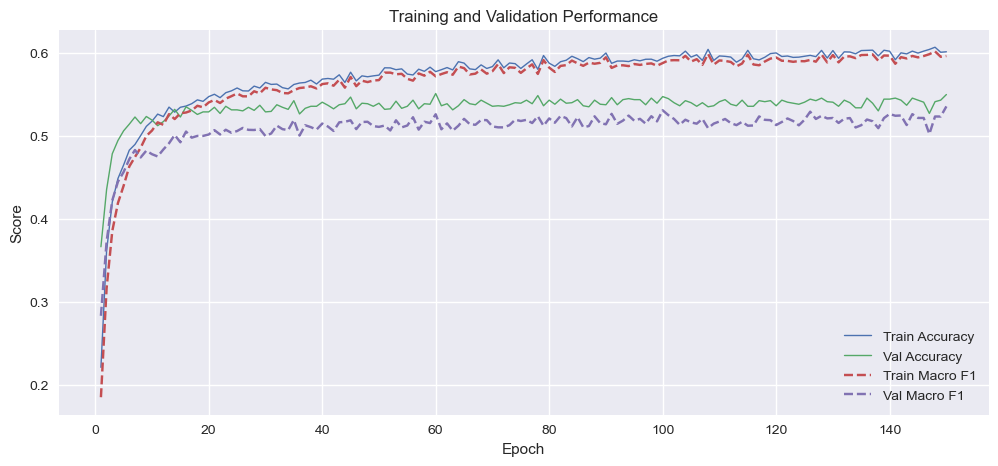

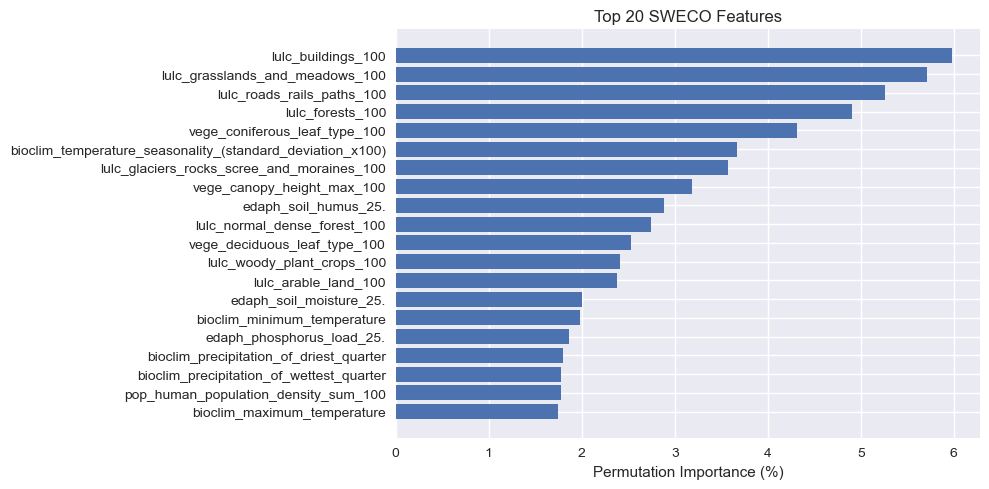

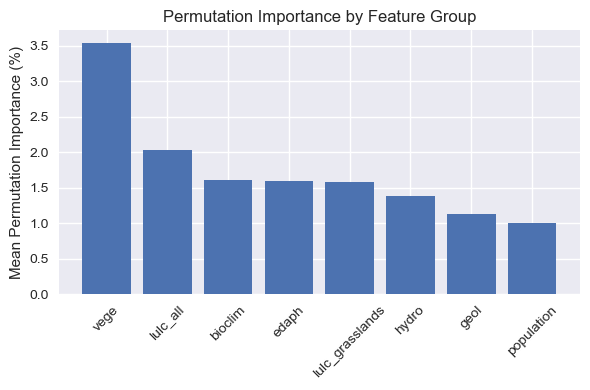

In [37]:
# 1. Dataloaders and model
input_dim = Xtrain_tensor.shape[1]

# --- Tabular models --- #
if selected_model in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
    # Tabular dataloaders
    train_loader, val_loader = make_dataloaders(Xtrain_tensor, ytrain_tensor, Xval_tensor, yval_tensor, batch_size=hparams['batch_size'], n_train_samples=n_train_samples)
    # Tabular models
    if selected_model == 'TabularStandard':
        model = TabularMLP(input_dim=input_dim, hidden_layers = [512,256,128], dropout=hparams['dropout_rate'], n_classes=17)
    elif selected_model == 'TabularSkip':
        model = TabularSkipMLP(input_dim=input_dim, hidden_dim=256, n_blocks=3, dropout=hparams["dropout_rate"], n_classes=17)
    else : 
        model = TabularShallowMLP(input_dim=input_dim, hidden_layers = [128,32], dropout=hparams['dropout_rate'], n_classes=17)

# --- Image models --- #
elif selected_model in ['Resnet50', 'Hypercolumn', 'CNNfeature']:
    # Image dataloaders
    train_loader, val_loader = make_image_dataloaders(zip_path="data/images.zip", train_ids=image_train_ids, val_ids=image_val_ids,
        y_train=train_df['EUNIS_cls'].values, y_val=val_df['EUNIS_cls'].values, train_transform=train_image_transform,
        val_transform=eval_image_transform, batch_size=hparams['batch_size'], n_train_samples=n_train_samples)
    # Image models
    if selected_model == 'Resnet50':
        model = ImageResNet50(n_classes=17, pretrained=True)
    elif selected_model == 'Hypercolumn':
        model = ImageHypercolumnResNet(n_classes=17, pretrained=True)
    else:
        model = ImageCNNFeatureMLP(n_classes=17, pretrained=True, hidden_dim=256, n_blocks=2, dropout=hparams['dropout_rate'])

# --- Combined models --- #
elif selected_model == 'Combined':
    # Combined dataloaders
    train_loader, val_loader = make_combined_dataloaders(Xtrain_tensor, Xval_tensor, train_df, val_df, zip_path="data/images.zip",
        train_ids=image_train_ids, val_ids=image_val_ids, train_transform=train_image_transform, val_transform=eval_image_transform,
        batch_size=hparams['batch_size'], n_train_samples=n_train_samples)
    # Combined model
    model = CombinedTabularImageModel(tabular_input_dim=input_dim, n_classes=17, tabular_hidden=[128,64],
        image_model=selected_image_model, pretrained=True, dropout=hparams['dropout_rate'])
else : 
    raise ValueError(f"Unknown model type: {selected_model}")

model = model.to(device)

# 2. Display of informations

# --- Display the number of samples --- #
num_train_samples = len(train_loader.dataset)
num_val_samples = len(val_loader.dataset)
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")

# ---- Experiment naming ---- # 
if selected_model.lower() == "combined":
    model_name_clean = f"{selected_model}_{selected_image_model}_{hparams_index}"
else:
    model_name_clean = f"{selected_model}_{hparams_index}"

experiment_name = f"{model_name_clean}"
model_path = f"models/{experiment_name}.pt"
plot_path  = f"figures/{experiment_name}_training.png"

print(f'Model : {model_name_clean}')
print(f'Hyperparameters used : {hparams}')

# 3. Loss & optimizer (weighted or not)
criterion, optimizer = get_loss_optimizer(model, ytrain=ytrain_tensor.numpy(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'],
                                          weighted=weighted, device=device)

# 4. Train
history, best_epoch, total_time = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=n_epochs, print_every=10, save_path=model_path, device=device)

# 5. Load best model
model.load_state_dict(torch.load(model_path))

# 6. Evaluate on validation
val_acc, val_f1, val_f1_per_class = evaluate_model(model, Xval_tensor, yval_tensor)

print("\n=== Model performance ===")
print(f"Best epoch: {best_epoch}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Macro F1: {val_f1:.4f}")

# 7. Display computational performance
avg_epoch_time = total_time / n_epochs
print("\n=== Computational Performance ===")
print(f"Total training time: {total_time:.2f} s")
print(f"Average training time per epoch: {avg_epoch_time:.2f} s")

# 8. Plot
plot_training_curves(history, save_path=plot_path)

if selected_model in ['TabularStandard', 'TabularSkip', 'TabularShallow', 'Combined']:
    feature_importances_pct, group_importances = compute_group_permutation_importance(model=model, X=Xval_tensor, y=yval_tensor, device=device,
    feature_names=sweco_variables, feature_groups=sweco_variables_dict, n_repeats=5, metric=lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'))

    plot_permutation_importances(feature_importances_pct, sweco_variables, group_importances, top_n=20,
                        save_path_top=f"figures/{experiment_name}_top_features.png", save_path_group=f"figures/{experiment_name}_group_features.png")
else:
    print("Permutation importance not computed for image-only models.")

# 9. Saving all the parameters and results in a CSV
experiment_log = {
    "model_name": model_name_clean,
    "dropout_rate": hparams['dropout_rate'],
    "learning_rate": hparams['learning_rate'],
    "batch_size": hparams['batch_size'],
    "weight_decay": hparams['weight_decay'],
    "weighted_ce": weighted,
    "n_train_samples": num_train_samples,
    "best_epoch": best_epoch,
    "val_acc": val_acc,
    "val_macro_f1": val_f1,
    "total_time_s": total_time,
    "avg_epoch_time_s": avg_epoch_time
}

log_experiment("experiment_log.csv", experiment_log)

<a id="82"></a>
### 8.2 Best Model Choice per Experiment (Hyperparameter Search)

The *select_best_experiments* function loads all previous experiment results and identifies the best-performing hyperparameter combination for each trained model variant.

In [38]:
log_path = "experiment_log.csv"

best_experiments = select_best_experiments(log_path)
best_experiments.head()

model_name  dropout_rate  learning_rate  batch_size  weight_decay  \
5   TabularShallow_3           0.2         0.0010          32        0.0001   
2      TabularSkip_1           0.5         0.0001          32        0.0001   
0  TabularStandard_0           0.2         0.0001          16        0.0000   

   ...   val_acc  val_macro_f1  total_time_s  avg_epoch_time_s  \
5  ...  0.575385      0.567213    132.627648          0.884184   
2  ...  0.035077      0.033674      3.436315          0.068726   
0  ...  0.117538      0.068655      3.278587          0.065572   

        base_model  
5   TabularShallow  
2      TabularSkip  
0  TabularStandard  

[3 rows x 13 columns]

The plot below shows an overview of scores across and for each models depending on the hyperparameters

Figure saved to figures/experiments_overview.png


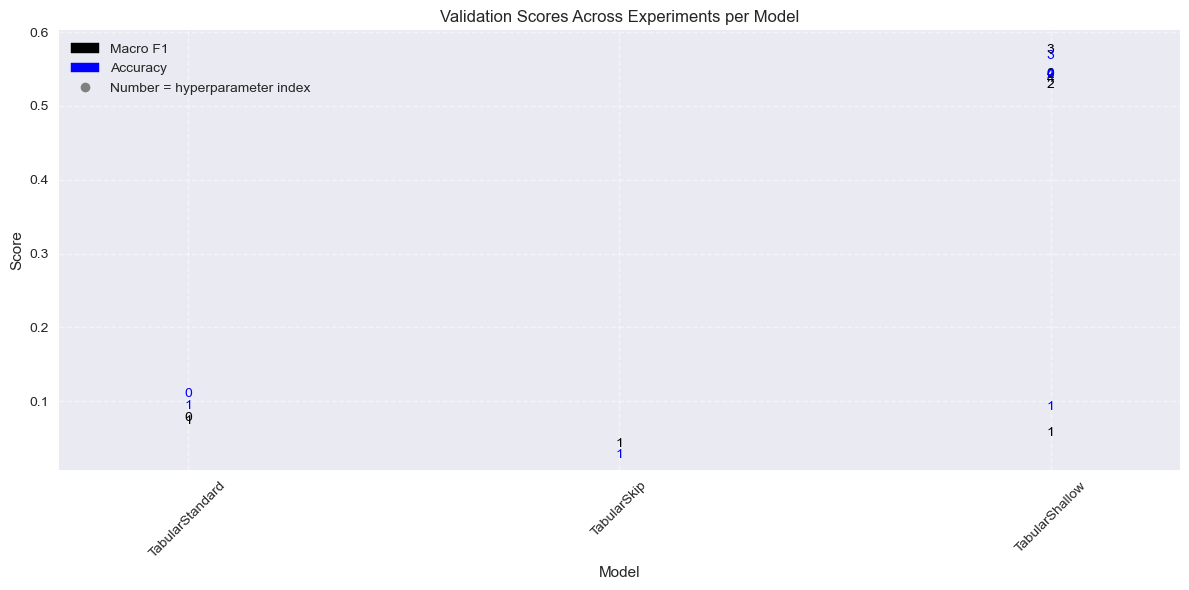

In [39]:
plot_experiments(log_path, save_path="figures/experiments_overview.png")

<a id="83"></a>
### 8.3 Best model choice by architecture (Tabular, Image, Combined)

From the best models per experiment, we further select the single best model for each architecture type : tabular-only, image-only, and combined, based on validation performance (e.g., macro F1 score). This reduces the set to three models in total, one representative per architecture, which will be used for final evaluation and visualization.

In [40]:
model_category = {
    'TabularStandard': 'Tabular',
    'TabularSkip': 'Tabular',
    'TabularShallow': 'Tabular',
    'Resnet50': 'Image',
    'Hypercolumn': 'Image',
    'CNNfeature': 'Image',
    'Combined_Resnet50': 'Combined',
    'Combined_Hypercolumn': 'Combined',
    'Combined_CNNfeature': 'Combined'
}

In [41]:
def get_best_model_for_category(df, category, model_category_mapping):
    filtered = df[df['base_model'].isin([k for k,v in model_category_mapping.items() if v==category])]
    if len(filtered) == 0:
        print(f"No model found for category '{category}'")
        return None
    return filtered.sort_values('val_macro_f1', ascending=False).iloc[0]

best_tabular = get_best_model_for_category(best_experiments, 'Tabular', model_category)
best_image = get_best_model_for_category(best_experiments, 'Image', model_category)
best_combined = get_best_model_for_category(best_experiments, 'Combined', model_category)

# Only keep non-None models
best_models = [m for m in [best_tabular, best_image, best_combined] if m is not None]
print(f'Best models : {best_models}')

No model found for category 'Image'
No model found for category 'Combined'
Best models : [model_name          TabularShallow_3
dropout_rate                     0.2
learning_rate                  0.001
batch_size                        32
weight_decay                  0.0001
weighted_ce                    False
n_train_samples                10200
best_epoch                       108
val_acc                     0.575385
val_macro_f1                0.567213
total_time_s              132.627648
avg_epoch_time_s            0.884184
base_model            TabularShallow
Name: 5, dtype: object]


<a id="9"></a>
## 9 Quantitative Results on Test Set (for the three architectures)

<a id="91"></a>
### 9.1 Test Data Preparation:

This function prepares the inputs (X) and labels (y) for evaluation or inference, adapting automatically to the model type. For tabular models, it returns the SWECO features tensor; for image models, it loads and transforms images from a zip file; for combined models, it returns both tabular and image inputs along with the labels.

In [42]:
def get_test_inputs(model_type, tabular_tensor=None, image_ids=None, df=None, zip_path=None, transform=None):
    """
    Returns X and y suitable for functions
    depending on model type.
    """
    if model_type in ['TabularStandard', 'TabularSkip', 'TabularShallow']:
        X = tabular_tensor
        y = tabular_tensor.new_tensor(df['EUNIS_cls'].values)
        return X, y

    elif model_type in ['Resnet50', 'Hypercolumn', 'CNNfeature']:
        dataset = ZipImageDataset(zip_path=zip_path, image_ids=image_ids, labels=df['EUNIS_cls'].values, transform=transform)
        X, y = zip(*[dataset[i] for i in range(len(dataset))])
        X = torch.stack(X)
        y = torch.tensor(y)
        return X, y

    elif model_type == 'Combined':
        dataset = CombinedDataset(tabular_tensor=tabular_tensor, df=df, zip_path=zip_path, image_ids=image_ids, transform=transform)
        X_tab, X_img, y = zip(*[dataset[i] for i in range(len(dataset))])
        X_tab = torch.stack(X_tab)
        X_img = torch.stack(X_img)
        y = torch.tensor(y)
        return (X_tab, X_img), y

    else:
        raise ValueError(f"Unknown model type: {model_type}")

<a id="92"></a>
### 9.2 Quantitative Results on Test Set

The code below evaluates the best models for each architecture (Tabular, Image, and Combined), on the held-out test set. For each of the three models, it performs the following evualation:

- **Evaluate predictive performance**, including overall accuracy, macro F1 score, per-class F1 scores, and inference time per sample.
- **Plot per-class F1 scores** to visualize class-level performance.
- **Compute permutation-based feature importance** for tabular and combined models, identifying which environmental variables most influence predictions, and visualize group-level importances.

By structuring the analysis this way, we provide a comprehensive yet compact overview of model performance, feature contributions, and potential multimodal gains.


=== Evaluating TabularShallow_3 ===
Accuracy: 0.5814
Macro F1: 0.5804
Inference time per sample: 0.0004 ms


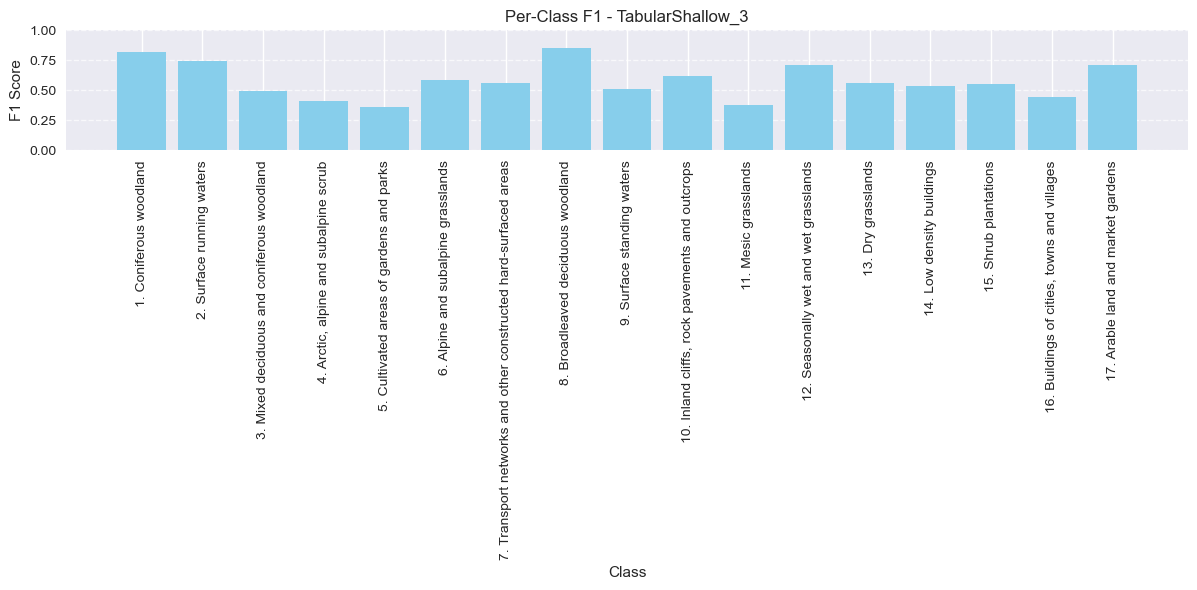

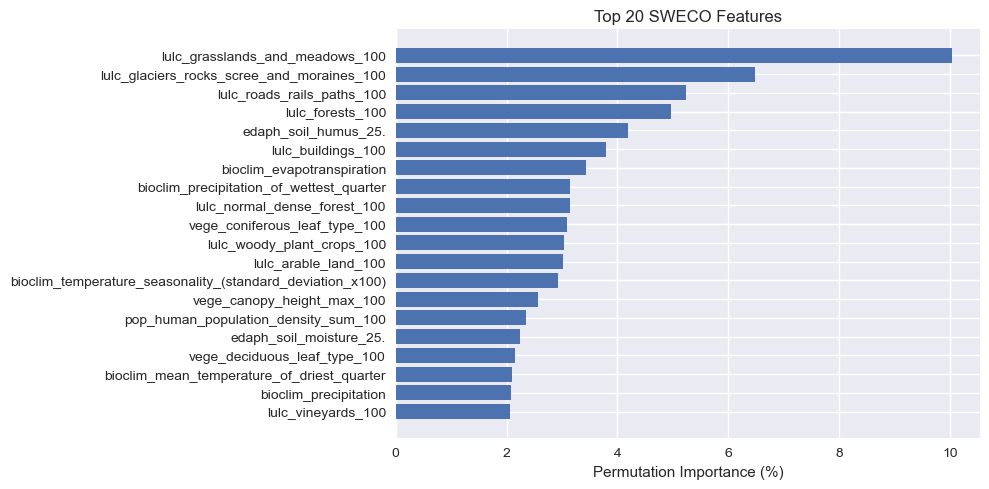

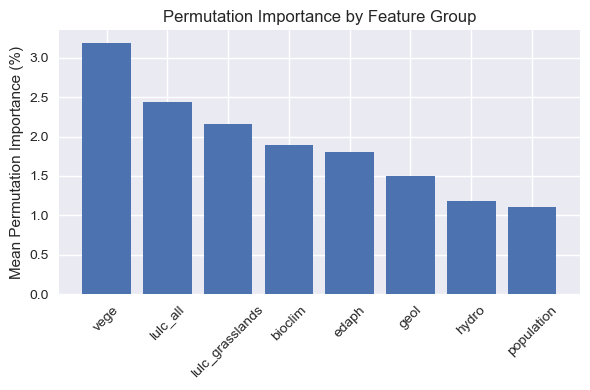

In [43]:
results = {}

for best_model_info in best_models:
    model_name = best_model_info['model_name']
    model_type = base_model_name(model_name)
    
    print(f"\n=== Evaluating {model_name} ===")
    
    # Load model
    model_path = f"models/{model_name}.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Prepare test inputs
    X_test, y_test = get_test_inputs(model_type=model_type, tabular_tensor=Xtest_tensor, image_ids=image_test_ids, df=test_df,
                                     zip_path="data/images.zip", transform=eval_image_transform)
    
    # Move inputs and labels to same device as model
    device = next(model.parameters()).device
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Evaluate performance
    test_acc, test_f1, test_f1_per_class = evaluate_model(model, X_test, y_test)
    test_inf_time = measure_inference_time(model, X_test)
    
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Macro F1: {test_f1:.4f}")
    print(f"Inference time per sample: {test_inf_time*1000:.4f} ms")
    
    # Store results
    results[model_name] = {"accuracy": test_acc, "macro_f1": test_f1, "per_class_f1": test_f1_per_class, "inference_time_s": test_inf_time}
    
    # Plot per-class F1
    plot_path_f1 = f"figures/{model_name}_per_class_f1.png"
    plot_per_class_f1(test_f1_per_class, class_labels=test_df['EUNIS_label'].unique(), title=f"Per-Class F1 - {model_name}", save_path=plot_path_f1)
    
    # If the model is tabular or combined, compute permutation importance
    if model_type in ['TabularStandard', 'TabularSkip', 'TabularShallow', 'Combined']:
        feature_importances_pct, group_importances = compute_group_permutation_importance(model=model, X=X_test, y=y_test, feature_names=sweco_variables,
                    feature_groups=sweco_variables_dict, n_repeats=5, metric=lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), device=device)
        plot_path_perm_group = f"figures/{model_name}_permutation_importance_group.png"
        plot_path_perm_top = f"figures/{model_name}_permutation_importance_top.png"
        plot_permutation_importances(feature_importances_pct, sweco_variables, group_importances, top_n=20,
                                     save_path_group=plot_path_perm_group, save_path_top=plot_path_perm_top)
    else:
        print("Permutation importance not computed for image-only models.")


<a id="10"></a>
## 10. Visual Analysis (with the best model only)

<a id="101"></a>
### 10.1 Selection of the best model

In [44]:
# Select the best model by macro F1
best_overall = max(best_models, key=lambda m: m['val_macro_f1'])
print(f'Best model : {best_overall}')
model_name = best_overall['model_name']
model_type = base_model_name(model_name)
model_path = f"models/{model_name}.pt"
model.load_state_dict(torch.load(model_path))
model.eval()

# Prepare test inputs
X_test, y_test = get_test_inputs(model_type=model_type, tabular_tensor=Xtest_tensor, image_ids=image_test_ids, df=test_df,
                                 zip_path="data/images.zip", transform=eval_image_transform)

# Move data to same device as model
device = next(model.parameters()).device
X_test = X_test.to(device)
y_test = y_test.to(device)

# Make predictions
with torch.no_grad():
    test_outputs = model(X_test)
    test_pred_labels = torch.argmax(test_outputs, dim=1)

Best model : model_name          TabularShallow_3
dropout_rate                     0.2
learning_rate                  0.001
batch_size                        32
weight_decay                  0.0001
weighted_ce                    False
n_train_samples                10200
best_epoch                       108
val_acc                     0.575385
val_macro_f1                0.567213
total_time_s              132.627648
avg_epoch_time_s            0.884184
base_model            TabularShallow
Name: 5, dtype: object


<a id="102"></a>
### 10.2 Confusion Matrix

- Best-performing model
- Analysis of frequent misclassifications

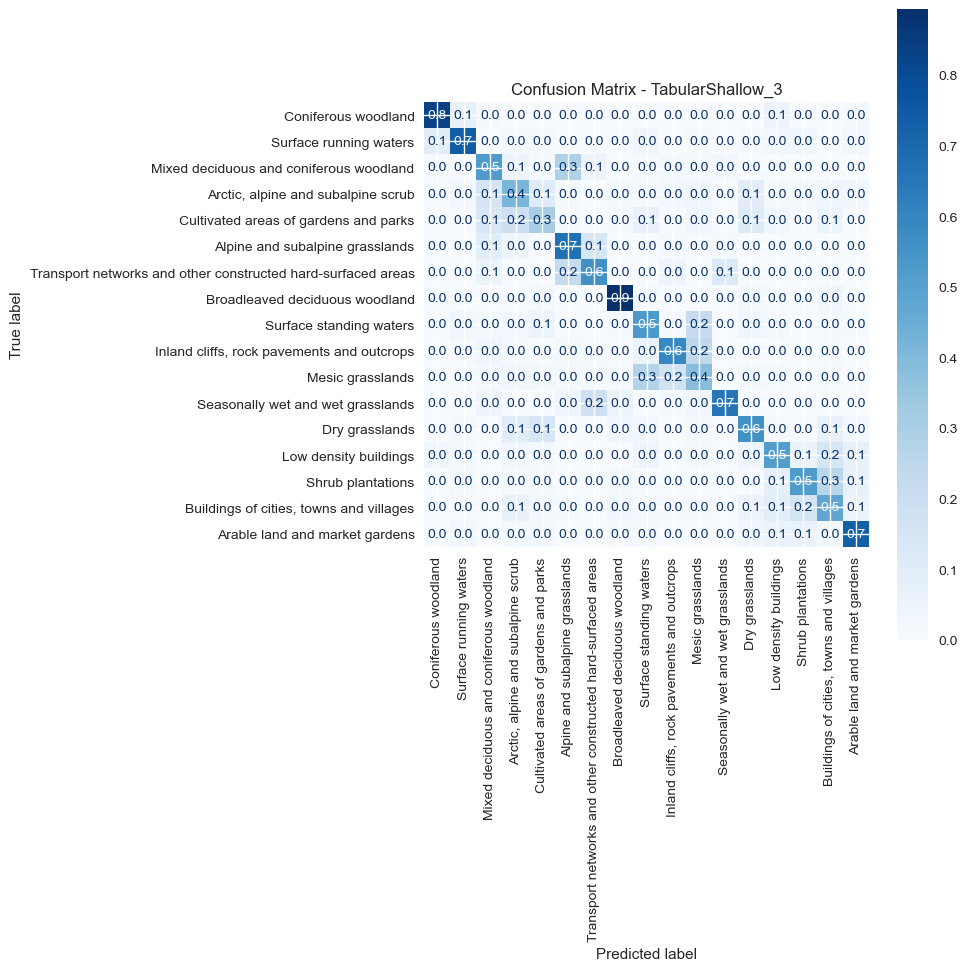

In [45]:
plot_path_confusion = f"figures/{model_name}_confusion.png"
plot_confusion_matrix(y_true=y_test, y_pred=test_pred_labels, class_labels=test_df['EUNIS_label'].unique(),
                      title=f"Confusion Matrix - {model_name}", save_path=plot_path_confusion)

<a id="103"></a>
### 10.3 Spatial Visualization

- Map predictions over Switzerland
- Compare predicted vs true ecosystems

We visualize predicted classes and prediction correctness on a map using *create_test_geodf* and *plot_predictions_map*.

In [46]:
def create_test_geodf(test_df, y_true, y_pred, x_col='x', y_col='y', crs=2056):
    """
    Convert test dataframe with predictions to a GeoDataFrame.
    
    Args:
        test_df: pandas DataFrame with coordinates and original data
        y_true: true labels (numpy array or torch tensor)
        y_pred: predicted labels (numpy array or torch tensor)
        x_col, y_col: column names for coordinates
        crs: initial CRS of the coordinates
    Returns:
        gdf: GeoDataFrame with predictions and correctness
    """
    # Ensure numpy arrays
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.numpy()
    
    correct = y_true == y_pred
    gdf = test_df.copy()
    gdf['pred_class'] = y_pred
    gdf['correct'] = correct
    gdf['geometry'] = [Point(xy) for xy in zip(gdf[x_col], gdf[y_col])]
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs=f"EPSG:{crs}")
    gdf = gdf.to_crs(epsg=3857)
    return gdf

def plot_predictions_map(gdf, column='pred_class', cmap='tab20', title="Predicted Classes", save_path = None):
    """
    Plot predicted classes or correctness on a basemap.
    
    Args:
        gdf: GeoDataFrame with 'geometry' and the column to color
        column: which column to plot ('pred_class' or 'correct')
        cmap: colormap
        title: plot title
    """
    fig, ax = plt.subplots(figsize=(12,8))
    gdf.plot(ax=ax, column=column, cmap=cmap, markersize=15, legend=True)
    ax.set_xlim(gdf.total_bounds[0]-10000, gdf.total_bounds[2]+10000)
    ax.set_ylim(gdf.total_bounds[1]-15000, gdf.total_bounds[3]+15000)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    plt.title(title)
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

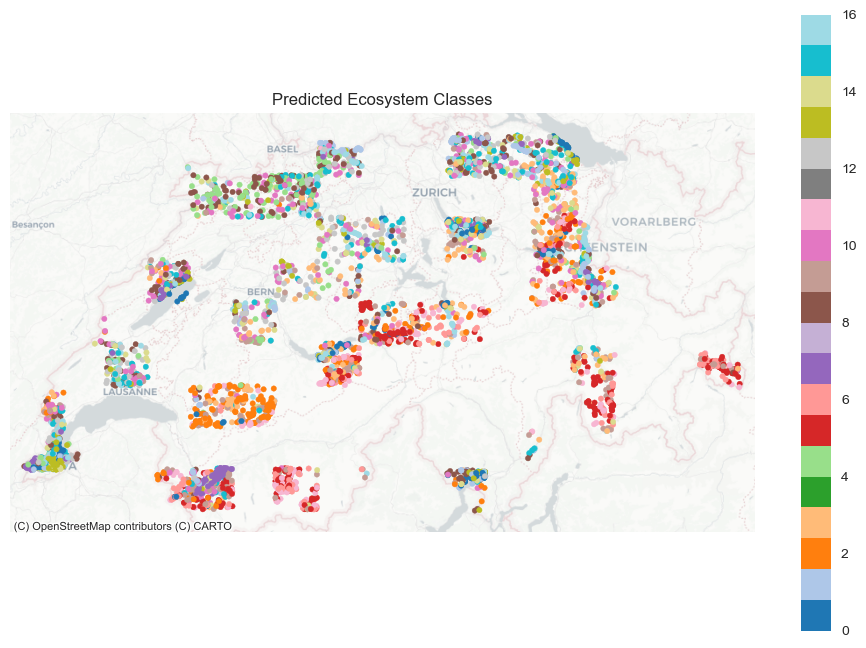

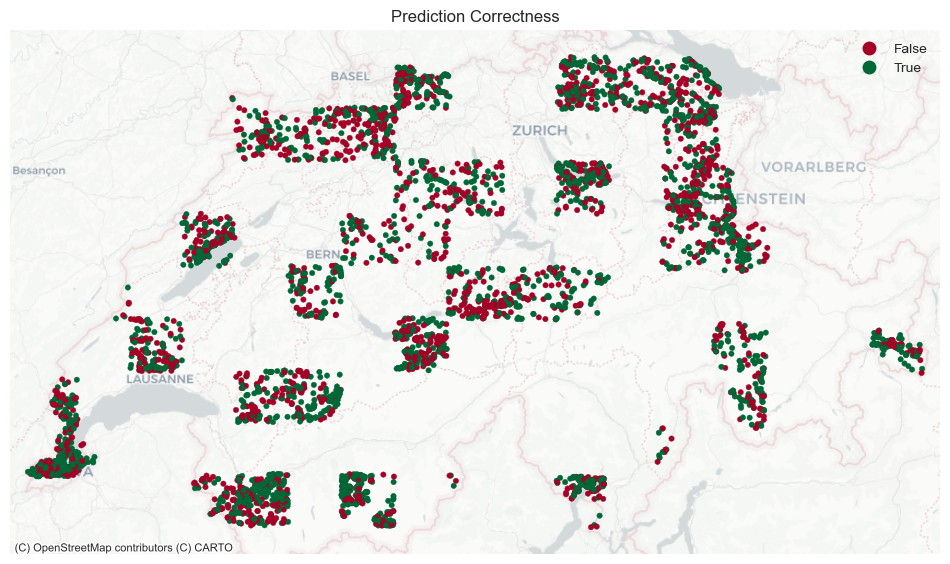

In [47]:
# Spatial visualization (works if the model has coordinates)
gdf_test = create_test_geodf(test_df, y_true=y_test, y_pred=test_pred_labels)
plot_predictions_map(gdf_test, column='pred_class', cmap='tab20', title="Predicted Ecosystem Classes", save_path=f"figures/{model_name}_pred_class.png")
plot_predictions_map(gdf_test, column='correct', cmap='RdYlGn', title="Prediction Correctness", save_path=f"figures/{model_name}_pred_correct.png")

<a id="10"></a>
## 10. Discussion (probably in the report)
<a id="101"></a>
### 10.1 Key Findings

- Main performance trends
- Complementarity between imagery and environmental variables

---

<a id="102"></a>
### 10.2 Scientific Interpretation

- Ecological meaning of important predictors
- What information imagery cannot capture alone

---

<a id="103"></a>
### 10.3 Limitations

- Class imbalance
- Spatial resolution constraints
- Model interpretability
- Limited temporal variability

<a id="11"></a>
## 11. Conclusion and Future Work (probably in the report)

- Summary of contributions
- Potential methodological improvements
- Future data extensions

<a id="12"></a>
## 12. Reproducibility (remove or move somewhere else)
<a id="121"></a>
### 12.1 Code Organization

- Notebook structure
- Scripts and modules used

---

<a id="122"></a>
### 12.2 How to Run

- Required libraries
- Hardware assumptions
- Random seed control

<a id="13"></a>
## 13. References